In [1]:
import os

import numpy as np
import skimage
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
from skimage.io import imread
from sklearn.metrics import roc_auc_score
from torch.utils.data import Dataset, DataLoader

from moco import SupConLoss, my_Densenet2

torch.cuda.empty_cache()

In [2]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


########## Mean and std are calculated from the train dataset
# normalize = transforms.Normalize(mean=[0.45271412, 0.45271412, 0.45271412],
#                                      std=[0.33165374, 0.33165374, 0.33165374])
# train_transformer = transforms.Compose([
#     transforms.Resize(256),
#     transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
#     transforms.RandomHorizontalFlip(),
# #     transforms.RandomRotation(90),
#     # random brightness and random contrast
#     transforms.ColorJitter(brightness=0.2, contrast=0.2),
#     transforms.ToTensor(),
#     normalize
# ])
class TwoCropTransform:
    """Create two crops of the same image"""

    def __init__(self, transform, transform2=None):
        self.transform = transform
        self.transform2 = transform if transform2 is None else transform2

    def __call__(self, x):
        return [self.transform(x), self.transform2(x)]


train_transform1 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])
train_transform2 = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(size=224, scale=(0.2, 1.)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    normalize,
])
train_transformer = TwoCropTransform(train_transform1, train_transform2)

val_transformer = transforms.Compose([
    #     transforms.Resize(224),
    #     transforms.CenterCrop(224),
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    normalize
])

In [3]:
'''Load LUNA dataset'''

# import h5py 
# import numpy as np
# import skimage
# import torch
# from torch.utils.data import DataLoader
# from torch.utils.data import TensorDataset
# f = h5py.File('all_patches.hdf5','r')
# f.keys()
# img = f['ct_slices'][:]  
# label = f['slice_class'][:] 
# f.close()
# print(np.shape(img))
# print('b',np.shape(label))
# skimage.io.imshow(img[120])
# print(label[120])
# batchsize=4

# class LungDataset(Dataset):
#     def __init__(self, img, label, transform=None):
#         self.img = img
#         self.label = label
#         self.transform = transform

#     def __len__(self):
#         return len(self.img)

#     def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()

#         image = PIL_image = Image.fromarray(self.img[idx]).convert('RGB')

#         if self.transform:
#             image = self.transform(image)
#         sample = {'img': image,
#                   'label': int(self.label[idx])}
#         return sample

# trainset = LungDataset(img, label, transform= val_transformer)
# valset = LungDataset(img, label, transform= val_transformer)
# train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
# val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
# modelname = 'medical_transfer'

'Load LUNA dataset'

In [4]:
batchsize = 10


def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data


class CovidCTDataset(Dataset):
    def __init__(self, root_dir, txt_COVID, txt_NonCOVID, transform=None):
        """
        Args:
            txt_path (string): Path to the txt file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        File structure:
        - root_dir
            - CT_COVID
                - img1.png
                - img2.png
                - ......
            - CT_NonCOVID
                - img1.png
                - img2.png
                - ......
        """
        self.root_dir = root_dir
        self.txt_path = [txt_COVID, txt_NonCOVID]
        self.classes = ['CT_COVID', 'CT_NonCOVID']
        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):
            cls_list = [[os.path.join(self.root_dir, self.classes[c], item), c] for item in read_txt(self.txt_path[c])]
            self.img_list += cls_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        sample = {'img': image,
                  'label': int(self.img_list[idx][1])}
        return sample


if __name__ == '__main__':
    trainset = CovidCTDataset(root_dir='/home/wangchenxu/covid/Images-processed',
                              txt_COVID='/home/wangchenxu/covid/Data-split/COVID/trainCT_COVID.txt',
                              txt_NonCOVID='/home/wangchenxu/covid/Data-split/NonCOVID/trainCT_NonCOVID.txt',
                              transform=train_transformer)
    valset = CovidCTDataset(root_dir='/home/wangchenxu/covid/Images-processed',
                            txt_COVID='/home/wangchenxu/covid/Data-split/COVID/valCT_COVID.txt',
                            txt_NonCOVID='/home/wangchenxu/covid/Data-split/NonCOVID/valCT_NonCOVID.txt',
                            transform=val_transformer)
    testset = CovidCTDataset(root_dir='/home/wangchenxu/covid/Images-processed',
                             txt_COVID='/home/wangchenxu/covid/Data-split/COVID/testCT_COVID.txt',
                             txt_NonCOVID='/home/wangchenxu/covid/Data-split/NonCOVID/testCT_NonCOVID.txt',
                             transform=val_transformer)
    print(trainset.__len__())
    print(valset.__len__())
    print(testset.__len__())

    train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
    val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
    test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)


425
118
203


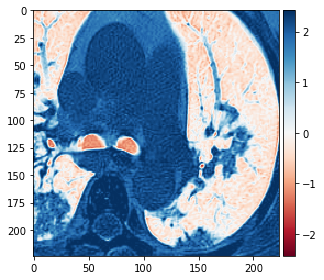

In [5]:
for batch_index, batch_samples in enumerate(train_loader):
    batch_samples['img'] = torch.cat([batch_samples['img'][0], batch_samples['img'][1]], dim=0)
    #         batch_samples['label'] = torch.cat([batch_samples['label'][0], batch_samples['label'][1]], dim=0)
    #           print(type(batch_samples['label']))
    #         print(batch_samples['label'])
    data, target = batch_samples['img'], batch_samples['label']
#         data = torch.cat([data[0],data[1]],dim=0)
#         print(target)
skimage.io.imshow(data[0, 1, :, :].numpy())
# data[0].shape,data[1].shape

In [6]:
#training process is defined here 

alpha = None
## alpha is None if mixup is not used
alpha_name = f'{alpha}'

device = 'cuda'


def train(optimizer, epoch):
    model.train()

    # train_loss = 0
    train_correct = 0
    criteria = nn.CrossEntropyLoss()
    criterion = SupConLoss.SupConLoss()

    for batch_index, batch_samples in enumerate(train_loader):

        # move data to device
        batch_samples['img'] = torch.cat([batch_samples['img'][0], batch_samples['img'][1]], dim=0)
        #         data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
        data, target = batch_samples['img'].cuda(), batch_samples['label'].cuda()

        ## adjust data to meet the input dimension of model
        #         data = data[:, 0, :, :]
        #         data = data[:, None, :, :]

        #mixup
        #         data, targets_a, targets_b, lam = mixup_data(data, target, alpha, use_cuda=True)

        #         target = target.cuda(None, non_blocking=True)
        optimizer.zero_grad()
        bsz = target.shape[0]

        output, features = model(data)
        #         out = model(data)
        #         output = out
        #         features = F.normalize(out, dim=1)

        loss1 = criteria(output, target.repeat(2).long())
        f1, f2 = torch.split(features, [bsz, bsz], dim=0)
        features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)
        loss2 = criterion(features, target.long())
        loss = loss1 + 0.01 * loss2
        #mixup loss
        #         loss = mixup_criterion(criteria, output, targets_a, targets_b, lam)

        # train_loss += loss1 + loss2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.repeat(2).long().view_as(pred)).sum().item()

        # Display progress and write to tensorboard
        if batch_index % bs == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(
                epoch, batch_index, len(train_loader),
                100.0 * batch_index / len(train_loader), loss.item() / bs))

#     print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         train_loss/len(train_loader.dataset), train_correct, len(train_loader.dataset),
#         100.0 * train_correct / len(train_loader.dataset)))
#     f = open('model_result/{}.txt'.format(modelname), 'a+')
#     f.write('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         train_loss/len(train_loader.dataset), train_correct, len(train_loader.dataset),
#         100.0 * train_correct / len(train_loader.dataset)))
#     f.write('\n')
#     f.close()

In [7]:
#val process is defined here

def val(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    results = []

    TP = 0
    TN = 0
    FN = 0
    FP = 0

    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []

        predlist = []
        scorelist = []
        targetlist = []
        # Predict
        for batch_index, batch_samples in enumerate(val_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)

            #             data = data[:, 0, :, :]
            #             data = data[:, None, :, :]
            output, feature = model(data)
            #             out = model(data)
            #             output = out
            #             feature = F.normalize(out, dim=1)
            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
            #             print('target',target.long()[:, 2].view_as(pred))
            correct += pred.eq(target.long().view_as(pred)).sum().item()

            #             print(output[:,1].cpu().numpy())
            #             print((output[:,1]+output[:,0]).cpu().numpy())
            #             predcpu=(output[:,1].cpu().numpy())/((output[:,1]+output[:,0]).cpu().numpy())
            targetcpu = target.long().cpu().numpy()
            predlist = np.append(predlist, pred.cpu().numpy())
            scorelist = np.append(scorelist, score.cpu().numpy()[:, 1])
            targetlist = np.append(targetlist, targetcpu)

    return targetlist, scorelist, predlist

    # Write to tensorboard

#     writer.add_scalar('Test Accuracy', 100.0 * correct / len(test_loader.dataset), epoch)

In [8]:
#test process is defined here 

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    results = []

    TP = 0
    TN = 0
    FN = 0
    FP = 0

    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []

        predlist = []
        scorelist = []
        targetlist = []
        # Predict
        for batch_index, batch_samples in enumerate(test_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
            #             data = data[:, 0, :, :]
            #             data = data[:, None, :, :]
            #             print(target)
            output, feature = model(data)
            #             out = model(data)
            #             output = out
            #             feature = F.normalize(out, dim=1)
            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
            #             print('target',target.long()[:, 2].view_as(pred))
            correct += pred.eq(target.long().view_as(pred)).sum().item()
            #             TP += ((pred == 1) & (target.long()[:, 2].view_as(pred).data == 1)).cpu().sum()
            #             TN += ((pred == 0) & (target.long()[:, 2].view_as(pred) == 0)).cpu().sum()
            # #             # FN    predict 0 label 1
            #             FN += ((pred == 0) & (target.long()[:, 2].view_as(pred) == 1)).cpu().sum()
            # #             # FP    predict 1 label 0
            #             FP += ((pred == 1) & (target.long()[:, 2].view_as(pred) == 0)).cpu().sum()
            #             print(TP,TN,FN,FP)

            #             print(output[:,1].cpu().numpy())
            #             print((output[:,1]+output[:,0]).cpu().numpy())
            #             predcpu=(output[:,1].cpu().numpy())/((output[:,1]+output[:,0]).cpu().numpy())
            targetcpu = target.long().cpu().numpy()
            predlist = np.append(predlist, pred.cpu().numpy())
            scorelist = np.append(scorelist, score.cpu().numpy()[:, 1])
            targetlist = np.append(targetlist, targetcpu)
    return targetlist, scorelist, predlist

    # Write to tensorboard

#     writer.add_scalar('Test Accuracy', 100.0 * correct / len(test_loader.dataset), epoch)

In [9]:
### Dense169

# model = models.densenet169(pretrained=True).cuda()
model = my_Densenet2.densenet169(pretrained=True).cuda()
# # modelname = 'Dense169'
"""load MoCo pretrained model"""
checkpoint = torch.load('save_model_dense1/checkpoint_luna_covid_KL+++.tar')
# # # print(checkpoint['arch'])

state_dict = checkpoint['state_dict']
for key in list(state_dict.keys()):
    if 'module.encoder_q' in key:
        #         print(key[17:])
        new_key = key[17:]
        state_dict[new_key] = state_dict[key]
    del state_dict[key]
# for key in list(state_dict.keys()):
#     if  key == 'classifier.0.weight':
#         new_key = 'classifier.weight'
#         state_dict[new_key] = state_dict[key]
#         del state_dict[key]
#     if  key == 'classifier.0.bias':
#         new_key = 'classifier.bias'
#         state_dict[new_key] = state_dict[key]
#         del state_dict[key]
#     if  key == 'classifier.2.weight' or key == 'classifier.2.bias':
#         new_key = key.replace('classifier.2', 'classifier2')
#         state_dict[new_key] = state_dict[key]
#         del state_dict[key]
# state_dict['classifier.weight'] = state_dict['classifier.weight'][:1000,:]
# state_dict['classifier.bias'] = state_dict['classifier.bias'][:1000]
model.load_state_dict(checkpoint['state_dict'])


class ModelWrapper(nn.Module):
    def __init__(self, model, num_features=128):
        super().__init__()
        self.model = model
        self.classifier = nn.Linear(num_features, 2)

    def forward(self, x):
        feat = self.model(x)
        logits = self.classifier(feat)
        target = F.normalize(feat,dim = 1)
        return logits, target


model = ModelWrapper(model).cuda()

In [10]:
"""Load Self-Trans model"""
"""Change names and locations to the Self-Trans.pt"""


# model = models.densenet169(pretrained=True).cuda()
# # pretrained_net = torch.load('model_backup/Dense169.pt')
# # pretrained_net = torch.load('model_backup/mixup/Dense169_0.6.pt')
# pretrained_net = torch.load('save_model_dense/Dense169_ssl_luna_moco_None_covid_moco_covid.pt')


# model.load_state_dict(pretrained_net)

# modelname = 'Dense169_ssl_luna_moco'

'Change names and locations to the Self-Trans.pt'

In [11]:
# train
bs = batchsize
votenum = 10
import warnings

warnings.filterwarnings('ignore')

r_list = []
p_list = []
acc_list = []
AUC_list = []
# TP = 0
# TN = 0
# FN = 0# FP = 0
vote_pred = np.zeros(valset.__len__())
vote_score = np.zeros(valset.__len__())

optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, weight_decay=1e-4)
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
total_epoch = 200
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_epoch)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)
# scheduler = StepLR(optimizer, step_size=1)

for epoch in range(1, total_epoch + 1):

    scheduler.step()
    train(optimizer, epoch)

    targetlist, scorelist, predlist = val(epoch)
    print('target', targetlist)
    print('score', scorelist)
    print('predict', predlist)
    vote_pred = vote_pred + predlist
    vote_score = vote_score + scorelist

    if epoch % votenum == 0:
        # major vote
        vote_pred[vote_pred <= (votenum / 2)] = 0
        vote_pred[vote_pred > (votenum / 2)] = 1
        vote_score = vote_score / votenum

        print('vote_pred', vote_pred)
        print('targetlist', targetlist)
        TP = ((vote_pred == 1) & (targetlist == 1)).sum()
        TN = ((vote_pred == 0) & (targetlist == 0)).sum()
        FN = ((vote_pred == 0) & (targetlist == 1)).sum()
        FP = ((vote_pred == 1) & (targetlist == 0)).sum()

        print('TP=', TP, 'TN=', TN, 'FN=', FN, 'FP=', FP)
        print('TP+FP', TP + FP)
        p = TP / (TP + FP)
        print('precision', p)
        p = TP / (TP + FP)
        r = TP / (TP + FN)
        print('recall', r)
        F1 = 2 * r * p / (r + p)
        acc = (TP + TN) / (TP + TN + FP + FN)
        print('F1', F1)
        print('acc', acc)
        AUC = roc_auc_score(targetlist, vote_score)
        print('AUCp', roc_auc_score(targetlist, vote_pred))
        print('AUC', AUC)

        #         if epoch == total_epoch:
        torch.save(model.state_dict(), "save_model_dense1/moco_covid_myDensenet++.pt")

        vote_pred = np.zeros(valset.__len__())
        vote_score = np.zeros(valset.__len__())
        print('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
            epoch, r, p, F1, acc, AUC))

#         f = open('model_result/medical_transfer/{}_{}.txt'.format(modelname,alpha_name), 'a+')
#         f.write('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
# average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
#         epoch, r, p, F1, acc, AUC))
#         f.close()



Train Epoch: 1 [0/43 (0%)]	Train Loss: 0.380022
Train Epoch: 1 [10/43 (23%)]	Train Loss: 0.087460
Train Epoch: 1 [20/43 (47%)]	Train Loss: 0.104142
Train Epoch: 1 [30/43 (70%)]	Train Loss: 0.277624
Train Epoch: 1 [40/43 (93%)]	Train Loss: 0.118302
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.99753976 0.96711105 0.85944206 0.80725873 0.35308003 0.94436198
 0.97952729 0.80727512 0.79342455 0.21205734 0.89675856 0.19260852
 0.11304358 0.42650574 0.19368348 0.81856817 0.04619696 0.27807254
 0.07295141 0.80582196 0.02265036 0.13476534 0.0532118  0.01306698
 0.0858332  0.15429945 0.43882629 0.29018986 0.26913086 0.23532961
 0.38535365 0.23322743 0.41570842 0.48274893

Train Epoch: 5 [0/43 (0%)]	Train Loss: 0.182787
Train Epoch: 5 [10/43 (23%)]	Train Loss: 0.172733
Train Epoch: 5 [20/43 (47%)]	Train Loss: 0.179224
Train Epoch: 5 [30/43 (70%)]	Train Loss: 0.153313
Train Epoch: 5 [40/43 (93%)]	Train Loss: 0.179481
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.0643453  0.99996912 0.99887496 0.50239152 0.51524121 0.43086267
 0.99988663 0.70567721 0.37856418 0.49517936 0.19050559 0.55989444
 0.46091363 0.61899197 0.72043544 0.62625057 0.28600565 0.97602582
 0.97081125 0.64115888 0.76411206 0.83425897 0.99364775 0.68804002
 0.64208752 0.97572416 0.97659588 0.98360115 0.89941537 0.98278749
 0.65795296 0.6930424  0.99989212 0.52989483

Train Epoch: 9 [0/43 (0%)]	Train Loss: 0.061982
Train Epoch: 9 [10/43 (23%)]	Train Loss: 0.064619
Train Epoch: 9 [20/43 (47%)]	Train Loss: 0.068924
Train Epoch: 9 [30/43 (70%)]	Train Loss: 0.085751
Train Epoch: 9 [40/43 (93%)]	Train Loss: 0.159008
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.40002111 0.98761719 0.66872543 0.35792956 0.47529998 0.41455328
 0.98810601 0.65886784 0.36679903 0.22457378 0.41644275 0.21559051
 0.22400801 0.44630489 0.32348222 0.29665518 0.42783803 0.69980365
 0.83985955 0.52673304 0.55193973 0.29191327 0.6866852  0.37399238
 0.28449973 0.39740038 0.5199815  0.65084606 0.3931998  0.50162429
 0.64213747 0.63747025 0.55549937 0.32642218

target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.65400976 0.92101681 0.66417992 0.74226087 0.55032045 0.26655972
 0.96801043 0.6654495  0.22755946 0.67585677 0.53221053 0.53732961
 0.69694597 0.96144307 0.89262199 0.57066631 0.81111258 0.54816502
 0.6740061  0.85352635 0.67741442 0.71670407 0.53603613 0.63102311
 0.81334794 0.695126   0.80200601 0.83137137 0.73565853 0.63397318
 0.75472838 0.82492143 0.82016039 0.65670508 0.64125842 0.5009563
 0.23619352 0.53090531 0.67435467 0.83021218 0.81025481 0.41927773
 0.77064508 0.4535369  0.50856352 0.64068753 0.80694228 0.92010671
 0.8680982  0.41906136 0.33727291 0.65483207 0.60004634 0.45028216
 0.73584229 0.54702199 0.

Train Epoch: 16 [0/43 (0%)]	Train Loss: 0.090385
Train Epoch: 16 [10/43 (23%)]	Train Loss: 0.086022
Train Epoch: 16 [20/43 (47%)]	Train Loss: 0.066629
Train Epoch: 16 [30/43 (70%)]	Train Loss: 0.070426
Train Epoch: 16 [40/43 (93%)]	Train Loss: 0.066583
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.71882451 0.52958888 0.54195791 0.38285178 0.3735449  0.32795048
 0.59658307 0.35533085 0.30474925 0.2291358  0.4222244  0.16373563
 0.41876206 0.65533853 0.69602078 0.54256409 0.43079454 0.45251209
 0.37672415 0.333507   0.33757675 0.43562779 0.44181606 0.47650898
 0.29558161 0.34993544 0.40147659 0.45429042 0.56316024 0.3590554
 0.43708637 0.55981117 0.702959   0.3685

Train Epoch: 20 [0/43 (0%)]	Train Loss: 0.058369
Train Epoch: 20 [10/43 (23%)]	Train Loss: 0.074842
Train Epoch: 20 [20/43 (47%)]	Train Loss: 0.071684
Train Epoch: 20 [30/43 (70%)]	Train Loss: 0.103722
Train Epoch: 20 [40/43 (93%)]	Train Loss: 0.080511
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.90616542 0.99796474 0.99835157 0.10145114 0.4004519  0.40354684
 0.9970811  0.23623382 0.32110003 0.15818179 0.27838114 0.11725904
 0.38859278 0.45454824 0.59925586 0.34041128 0.33453518 0.37910792
 0.44902927 0.37814665 0.40826932 0.58398414 0.41399249 0.32284576
 0.30879205 0.24987137 0.44478747 0.41195181 0.42946887 0.41181195
 0.26869062 0.58545864 0.99903595 0.225

Train Epoch: 23 [0/43 (0%)]	Train Loss: 0.072154
Train Epoch: 23 [10/43 (23%)]	Train Loss: 0.062719
Train Epoch: 23 [20/43 (47%)]	Train Loss: 0.085492
Train Epoch: 23 [30/43 (70%)]	Train Loss: 0.066601
Train Epoch: 23 [40/43 (93%)]	Train Loss: 0.084182
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.15132262 0.78000093 0.71792257 0.50317526 0.0454572  0.64849788
 0.72744405 0.90154797 0.48638982 0.11584008 0.20681332 0.16012378
 0.43045026 0.59483707 0.65975153 0.43029946 0.44442275 0.51971167
 0.41207743 0.43606049 0.55484176 0.33875248 0.56797528 0.53284162
 0.51510733 0.60666519 0.59052056 0.57188946 0.54213184 0.51153588
 0.62601906 0.508798   0.8000651  0.590

Train Epoch: 27 [0/43 (0%)]	Train Loss: 0.060517
Train Epoch: 27 [10/43 (23%)]	Train Loss: 0.106530
Train Epoch: 27 [20/43 (47%)]	Train Loss: 0.070724
Train Epoch: 27 [30/43 (70%)]	Train Loss: 0.069308
Train Epoch: 27 [40/43 (93%)]	Train Loss: 0.062005
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.38395292 0.67042023 0.72086513 0.37916505 0.07596529 0.04502109
 0.76876146 0.5254457  0.05039241 0.04920319 0.07142048 0.0528506
 0.09079936 0.37699571 0.24907859 0.44300094 0.33770549 0.41469151
 0.37596923 0.61584634 0.58480227 0.4655765  0.63185996 0.46509469
 0.5099321  0.60205609 0.66720188 0.60379785 0.39047721 0.3462857
 0.73277354 0.53667992 0.69683391 0.02767


 The epoch is 30, average recall: 0.7931, average precision: 0.6571,average F1: 0.7188, average accuracy: 0.6949, average AUC: 0.7787
Train Epoch: 31 [0/43 (0%)]	Train Loss: 0.063912
Train Epoch: 31 [10/43 (23%)]	Train Loss: 0.079738
Train Epoch: 31 [20/43 (47%)]	Train Loss: 0.093830
Train Epoch: 31 [30/43 (70%)]	Train Loss: 0.065049
Train Epoch: 31 [40/43 (93%)]	Train Loss: 0.074664
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.06239183 0.81040144 0.86491114 0.02389848 0.03365016 0.11315719
 0.67348373 0.01842594 0.03338718 0.04458434 0.03695326 0.02370887
 0.03017236 0.64103138 0.36049604 0.65941781 0.57047009 0.51228875
 0.65051115 0.53724444 0.62694705 0.39

Train Epoch: 35 [0/43 (0%)]	Train Loss: 0.065475
Train Epoch: 35 [10/43 (23%)]	Train Loss: 0.098199
Train Epoch: 35 [20/43 (47%)]	Train Loss: 0.054282
Train Epoch: 35 [30/43 (70%)]	Train Loss: 0.076068
Train Epoch: 35 [40/43 (93%)]	Train Loss: 0.083048
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.32778707 0.8131302  0.76759976 0.55605376 0.28543276 0.40905792
 0.89076895 0.75025541 0.28873667 0.16283809 0.23216574 0.12949786
 0.23269898 0.44461548 0.53856748 0.34096929 0.23864293 0.34789938
 0.9789353  0.9582001  0.92521286 0.26974031 0.32955259 0.3557626
 0.17708749 0.32654706 0.98191488 0.59903318 0.15266702 0.47299743
 0.57939053 0.57265598 0.70051277 0.3134

Train Epoch: 39 [0/43 (0%)]	Train Loss: 0.069252
Train Epoch: 39 [10/43 (23%)]	Train Loss: 0.090457
Train Epoch: 39 [20/43 (47%)]	Train Loss: 0.062691
Train Epoch: 39 [30/43 (70%)]	Train Loss: 0.069297
Train Epoch: 39 [40/43 (93%)]	Train Loss: 0.059664
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.28230032 0.90251255 0.8635391  0.20170464 0.11282353 0.19053347
 0.86335522 0.27575716 0.22511636 0.15882018 0.17703724 0.16428581
 0.22720054 0.83740884 0.68168586 0.70795572 0.32194272 0.67866492
 0.64646053 0.5898295  0.55913758 0.56336677 0.50348943 0.47264752
 0.31763169 0.63074535 0.80761313 0.42301026 0.38589558 0.53468561
 0.66816938 0.51642042 0.65191746 0.185

Train Epoch: 42 [40/43 (93%)]	Train Loss: 0.064483
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.56127203 0.73268777 0.89611512 0.64897156 0.67538649 0.64713073
 0.82080185 0.67789775 0.40250072 0.57695973 0.34238422 0.54308587
 0.39621851 0.62944895 0.65801972 0.56709558 0.31349224 0.36479616
 0.56113029 0.52257097 0.60415971 0.39629838 0.69596636 0.70311219
 0.48530751 0.69016707 0.74901068 0.72314751 0.31753474 0.46548352
 0.66502887 0.38973749 0.6442396  0.38462257 0.58242524 0.51133758
 0.41183043 0.34843096 0.54922169 0.47689921 0.59255087 0.78881514
 0.56758827 0.25151533 0.36008811 0.56566817 0.69695139 0.461725
 0.6346494  0.46662104 0.5201624  0.758307

Train Epoch: 46 [0/43 (0%)]	Train Loss: 0.074025
Train Epoch: 46 [10/43 (23%)]	Train Loss: 0.088231
Train Epoch: 46 [20/43 (47%)]	Train Loss: 0.052565
Train Epoch: 46 [30/43 (70%)]	Train Loss: 0.072956
Train Epoch: 46 [40/43 (93%)]	Train Loss: 0.092684
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.69550467 0.94231659 0.85392213 0.75852674 0.69589281 0.44938961
 0.93937629 0.60839367 0.54663479 0.46993345 0.79124957 0.62402838
 0.47048271 0.77977121 0.89267051 0.50218648 0.51733381 0.36583742
 0.40903035 0.37117821 0.52395916 0.49559632 0.71563017 0.72512162
 0.25446406 0.6595695  0.74802244 0.52751911 0.52453136 0.36841175
 0.81221575 0.7493754  0.78526473 0.719

Train Epoch: 50 [0/43 (0%)]	Train Loss: 0.054930
Train Epoch: 50 [10/43 (23%)]	Train Loss: 0.073610
Train Epoch: 50 [20/43 (47%)]	Train Loss: 0.100320
Train Epoch: 50 [30/43 (70%)]	Train Loss: 0.065149
Train Epoch: 50 [40/43 (93%)]	Train Loss: 0.079159
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.5559696  0.96227938 0.92959636 0.48811468 0.66219747 0.66237259
 0.9391849  0.72643423 0.35751328 0.59601218 0.61192507 0.4843407
 0.55702889 0.77324021 0.69419664 0.63563609 0.35446924 0.53654534
 0.4321661  0.66004604 0.47986621 0.64787519 0.72318929 0.71025723
 0.68913144 0.71468252 0.68590343 0.68216014 0.42420802 0.57232547
 0.87650794 0.6640408  0.86177242 0.5584

Train Epoch: 53 [40/43 (93%)]	Train Loss: 0.054409
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.60554016 0.96218956 0.96829671 0.43640071 0.20798358 0.41560224
 0.86846393 0.74683839 0.27851477 0.1695174  0.14774761 0.17166123
 0.27316388 0.7681672  0.64545888 0.13747914 0.25303578 0.68181211
 0.72043431 0.29346365 0.4545005  0.37516323 0.67313194 0.93075532
 0.34808594 0.52004427 0.81383348 0.50302267 0.24191587 0.35847709
 0.55242938 0.7356708  0.48523441 0.03578138 0.0649426  0.04473973
 0.11105534 0.13485126 0.33239648 0.39976695 0.38209721 0.29006714
 0.2603294  0.32101467 0.09843868 0.25547901 0.27646774 0.35595092
 0.88785887 0.23924465 0.30241743 0.1191

Train Epoch: 57 [0/43 (0%)]	Train Loss: 0.060895
Train Epoch: 57 [10/43 (23%)]	Train Loss: 0.080998
Train Epoch: 57 [20/43 (47%)]	Train Loss: 0.063685
Train Epoch: 57 [30/43 (70%)]	Train Loss: 0.045174
Train Epoch: 57 [40/43 (93%)]	Train Loss: 0.085801
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.60290641 0.93367606 0.97836065 0.94075733 0.88986301 0.82466507
 0.85781384 0.92757726 0.75238848 0.88015568 0.94971842 0.91395611
 0.9452433  0.80343324 0.81371969 0.67075402 0.51652586 0.62551719
 0.32365686 0.48020506 0.30617818 0.32234642 0.84140193 0.95573038
 0.7112239  0.60406941 0.93861115 0.80280823 0.56996846 0.39071268
 0.84687418 0.78035188 0.62241459 0.483


 The epoch is 60, average recall: 0.8793, average precision: 0.6456,average F1: 0.7445, average accuracy: 0.7034, average AUC: 0.7805
Train Epoch: 61 [0/43 (0%)]	Train Loss: 0.049630
Train Epoch: 61 [10/43 (23%)]	Train Loss: 0.084878
Train Epoch: 61 [20/43 (47%)]	Train Loss: 0.116439
Train Epoch: 61 [30/43 (70%)]	Train Loss: 0.059173
Train Epoch: 61 [40/43 (93%)]	Train Loss: 0.072116
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.53363866 0.86044323 0.96980661 0.49832529 0.8019734  0.72177368
 0.85541356 0.89570403 0.70861387 0.63409156 0.42125487 0.51311243
 0.59635437 0.90981174 0.94679379 0.59156466 0.66495293 0.62159514
 0.51543099 0.34612843 0.25350401 0.57

Train Epoch: 65 [0/43 (0%)]	Train Loss: 0.073361
Train Epoch: 65 [10/43 (23%)]	Train Loss: 0.057009
Train Epoch: 65 [20/43 (47%)]	Train Loss: 0.055845
Train Epoch: 65 [30/43 (70%)]	Train Loss: 0.059295
Train Epoch: 65 [40/43 (93%)]	Train Loss: 0.100738
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.43100944 0.96936774 0.92148387 0.17156301 0.49184224 0.36028346
 0.88196969 0.32981688 0.48283666 0.5636484  0.60633254 0.3024599
 0.47273216 0.70610702 0.74485517 0.2014349  0.17566909 0.60402089
 0.62169099 0.44825706 0.36711422 0.42117971 0.78559524 0.6612308
 0.23724596 0.67657644 0.93420815 0.39183515 0.3596743  0.38774687
 0.79317731 0.5099293  0.31274882 0.13041

Train Epoch: 69 [0/43 (0%)]	Train Loss: 0.055749
Train Epoch: 69 [10/43 (23%)]	Train Loss: 0.072227
Train Epoch: 69 [20/43 (47%)]	Train Loss: 0.061573
Train Epoch: 69 [30/43 (70%)]	Train Loss: 0.050620
Train Epoch: 69 [40/43 (93%)]	Train Loss: 0.022934
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.56771195 0.85056621 0.91910994 0.61813033 0.41251627 0.30981684
 0.84487438 0.5258708  0.37594324 0.17155518 0.17848992 0.18905224
 0.12904949 0.61900628 0.54432917 0.13418336 0.21936359 0.65715772
 0.68916821 0.40217453 0.32735667 0.45314169 0.87712532 0.85170996
 0.48520839 0.79488814 0.94760352 0.33440635 0.2761108  0.35054848
 0.75588381 0.48411387 0.48457667 0.172

target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.4258253  0.80136609 0.86265641 0.7784242  0.79601687 0.00482642
 0.89422429 0.62211365 0.46002731 0.00595107 0.0061607  0.00310572
 0.00519352 0.57396692 0.93779856 0.22708645 0.61219591 0.24582724
 0.13389955 0.4556587  0.19848959 0.37844303 0.74556875 0.78898227
 0.32036382 0.80872661 0.76816207 0.63374305 0.17053482 0.28706029
 0.79274768 0.46832108 0.30678913 0.00370639 0.16695225 0.11592736
 0.41051069 0.50118715 0.12477671 0.20381667 0.14968593 0.05628554
 0.07010433 0.26755911 0.44376886 0.00268736 0.00740898 0.00213453
 0.0023821  0.00137978 0.00295724 0.00501801 0.00359012 0.00298616
 0.35755637 0.0022932  0

Train Epoch: 76 [0/43 (0%)]	Train Loss: 0.045432
Train Epoch: 76 [10/43 (23%)]	Train Loss: 0.094449
Train Epoch: 76 [20/43 (47%)]	Train Loss: 0.041026
Train Epoch: 76 [30/43 (70%)]	Train Loss: 0.065838
Train Epoch: 76 [40/43 (93%)]	Train Loss: 0.060075
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.274331   0.87740225 0.73517233 0.64101481 0.49712116 0.33678669
 0.75330466 0.54893714 0.3866919  0.35871583 0.48791632 0.19979712
 0.49755633 0.9934749  0.77894819 0.28412661 0.49522397 0.95793742
 0.8422026  0.67865205 0.52958888 0.88744909 0.99392128 0.95543808
 0.59248143 0.97526324 0.99586546 0.98064947 0.85572916 0.96552491
 0.94300115 0.83173209 0.30625823 0.173

Train Epoch: 80 [0/43 (0%)]	Train Loss: 0.047170
Train Epoch: 80 [10/43 (23%)]	Train Loss: 0.099753
Train Epoch: 80 [20/43 (47%)]	Train Loss: 0.050282
Train Epoch: 80 [30/43 (70%)]	Train Loss: 0.023139
Train Epoch: 80 [40/43 (93%)]	Train Loss: 0.077050
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.06483033 0.65338987 0.56165564 0.30787107 0.40056953 0.00252818
 0.4399505  0.55306739 0.38045105 0.00463414 0.10175361 0.00149096
 0.26358864 0.76473844 0.8898297  0.22108379 0.61766958 0.36234343
 0.11119802 0.38636726 0.58878541 0.71835536 0.21920963 0.74108636
 0.38445613 0.46527222 0.75240493 0.66097021 0.24719259 0.30863431
 0.74076426 0.58014292 0.45384026 0.028

Train Epoch: 83 [40/43 (93%)]	Train Loss: 0.057655
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.48946285 0.83004951 0.45893687 0.78996706 0.32233304 0.4968242
 0.42004448 0.44986182 0.36138454 0.0717189  0.53458297 0.0706436
 0.44077426 0.83122325 0.52880681 0.06939396 0.32447693 0.61076707
 0.45286041 0.44418621 0.48953801 0.41469091 0.85824478 0.69248885
 0.64172566 0.85616535 0.76701659 0.46731368 0.211438   0.66762924
 0.87846553 0.58150506 0.72205299 0.04177466 0.02493249 0.09331036
 0.22201656 0.60680097 0.41146117 0.31439829 0.3586494  0.25967458
 0.73599076 0.41796076 0.40966457 0.81941175 0.06041742 0.5000577
 0.03510698 0.03849575 0.03460221 0.0554191

Train Epoch: 87 [0/43 (0%)]	Train Loss: 0.043477
Train Epoch: 87 [10/43 (23%)]	Train Loss: 0.061605
Train Epoch: 87 [20/43 (47%)]	Train Loss: 0.081843
Train Epoch: 87 [30/43 (70%)]	Train Loss: 0.071430
Train Epoch: 87 [40/43 (93%)]	Train Loss: 0.066467
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.12284185 0.88391781 0.86963266 0.38646805 0.22435308 0.2150695
 0.77267337 0.31580126 0.3244262  0.77214044 0.48393673 0.63275486
 0.14871986 0.96096033 0.90173006 0.21966913 0.35451272 0.89425081
 0.73955214 0.45331529 0.3608512  0.70235264 0.98153138 0.91841197
 0.8898555  0.9681648  0.98386985 0.82628793 0.74855262 0.73696262
 0.817011   0.87472385 0.46692222 0.8333


 The epoch is 90, average recall: 0.7759, average precision: 0.7500,average F1: 0.7627, average accuracy: 0.7627, average AUC: 0.8187
Train Epoch: 91 [0/43 (0%)]	Train Loss: 0.078357
Train Epoch: 91 [10/43 (23%)]	Train Loss: 0.048364
Train Epoch: 91 [20/43 (47%)]	Train Loss: 0.075513
Train Epoch: 91 [30/43 (70%)]	Train Loss: 0.030412
Train Epoch: 91 [40/43 (93%)]	Train Loss: 0.067033
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.06611716 0.57341582 0.4792904  0.49232998 0.72038454 0.6804018
 0.43390286 0.50797242 0.19131517 0.4932873  0.28262389 0.48667902
 0.26376992 0.91785246 0.35532454 0.31388217 0.67449272 0.8265205
 0.88273495 0.59448606 0.65547556 0.6266

Train Epoch: 95 [0/43 (0%)]	Train Loss: 0.031354
Train Epoch: 95 [10/43 (23%)]	Train Loss: 0.055909
Train Epoch: 95 [20/43 (47%)]	Train Loss: 0.052812
Train Epoch: 95 [30/43 (70%)]	Train Loss: 0.071707
Train Epoch: 95 [40/43 (93%)]	Train Loss: 0.047039
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.56366295 0.4952687  0.47146404 0.36025229 0.38563418 0.30765226
 0.4296051  0.1841405  0.17132656 0.66524053 0.41879636 0.29252762
 0.16955346 0.48923671 0.10495447 0.10044221 0.23465858 0.61451566
 0.33135048 0.26947609 0.40234837 0.50173163 0.9629584  0.68552834
 0.3444964  0.95993608 0.38352334 0.29424152 0.21518537 0.35351348
 0.72507405 0.54342228 0.25393152 0.155

Train Epoch: 99 [0/43 (0%)]	Train Loss: 0.039843
Train Epoch: 99 [10/43 (23%)]	Train Loss: 0.032758
Train Epoch: 99 [20/43 (47%)]	Train Loss: 0.048547
Train Epoch: 99 [30/43 (70%)]	Train Loss: 0.046163
Train Epoch: 99 [40/43 (93%)]	Train Loss: 0.053237
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.80540848 0.57467812 0.55203372 0.95650214 0.82177335 0.92032027
 0.39457589 0.21222876 0.9096694  0.54889536 0.40212288 0.68547785
 0.33526105 0.97319818 0.57936877 0.9542262  0.15374672 0.35880074
 0.90977681 0.85536683 0.89374685 0.53790879 0.97975004 0.88555348
 0.86665279 0.9003849  0.90704542 0.91195542 0.29229215 0.39980555
 0.84368366 0.55833352 0.3924202  0.705

Train Epoch: 102 [40/43 (93%)]	Train Loss: 0.089310
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.28132665 0.70657766 0.65196812 0.663634   0.5446164  0.32044426
 0.61727095 0.72887123 0.59830165 0.19670132 0.18663611 0.21667606
 0.73956436 0.62893754 0.44793794 0.10188171 0.37671342 0.37785923
 0.15888153 0.51667881 0.3670018  0.77067524 0.91320103 0.8819499
 0.43258715 0.89371914 0.84015852 0.68406725 0.29816583 0.50790679
 0.92314517 0.51072615 0.06720945 0.10148292 0.0140509  0.02661539
 0.13637114 0.62972873 0.66714334 0.08913884 0.34123826 0.3185057
 0.13596712 0.22463077 0.33622712 0.26584014 0.1829536  0.12805405
 0.29922491 0.26938781 0.21254946 0.07268

Train Epoch: 106 [0/43 (0%)]	Train Loss: 0.029084
Train Epoch: 106 [10/43 (23%)]	Train Loss: 0.058230
Train Epoch: 106 [20/43 (47%)]	Train Loss: 0.050735
Train Epoch: 106 [30/43 (70%)]	Train Loss: 0.024961
Train Epoch: 106 [40/43 (93%)]	Train Loss: 0.062231
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.0561747  0.9129768  0.85790318 0.60662979 0.16665858 0.13267061
 0.86772883 0.66279918 0.54896456 0.10240562 0.43429109 0.17218356
 0.72871923 0.91613013 0.94699633 0.38518697 0.58785611 0.48549312
 0.94055998 0.62303197 0.45801148 0.87040961 0.99049395 0.87965113
 0.83126467 0.92346597 0.15396266 0.84386009 0.7419427  0.80238187
 0.9111293  0.80269933 0.5357753  

Train Epoch: 110 [0/43 (0%)]	Train Loss: 0.098134
Train Epoch: 110 [10/43 (23%)]	Train Loss: 0.027944
Train Epoch: 110 [20/43 (47%)]	Train Loss: 0.037150
Train Epoch: 110 [30/43 (70%)]	Train Loss: 0.073792
Train Epoch: 110 [40/43 (93%)]	Train Loss: 0.047275
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.08627332 0.73923063 0.7948581  0.43499205 0.38581839 0.04757083
 0.87410587 0.38163352 0.08892917 0.05245269 0.10626069 0.10926403
 0.36377159 0.89850652 0.88454825 0.34603298 0.37647459 0.22312924
 0.34604406 0.54645109 0.63518542 0.72942966 0.90962511 0.76985067
 0.61394417 0.89128113 0.80890781 0.74545252 0.30579805 0.17308243
 0.79140455 0.50464702 0.17270815 

Train Epoch: 113 [40/43 (93%)]	Train Loss: 0.036927
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.24998745 0.35055044 0.53305072 0.63569671 0.22950631 0.3108862
 0.35241234 0.57777846 0.38792393 0.22686338 0.41031    0.24449311
 0.7671243  0.66975534 0.31614032 0.2537747  0.4718895  0.4062303
 0.26912385 0.38487443 0.13104272 0.82752681 0.97034585 0.24870951
 0.65162927 0.88591129 0.17555089 0.76281673 0.34878948 0.23706339
 0.82779682 0.42903543 0.0219955  0.2617504  0.08356296 0.1673695
 0.27887771 0.47868451 0.63048053 0.12359933 0.22517309 0.61281765
 0.27529365 0.14903504 0.41462946 0.22767501 0.11920236 0.11635145
 0.47906896 0.34222519 0.22734922 0.238207

Train Epoch: 117 [0/43 (0%)]	Train Loss: 0.040314
Train Epoch: 117 [10/43 (23%)]	Train Loss: 0.056633
Train Epoch: 117 [20/43 (47%)]	Train Loss: 0.040206
Train Epoch: 117 [30/43 (70%)]	Train Loss: 0.042594
Train Epoch: 117 [40/43 (93%)]	Train Loss: 0.055915
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.29303873 0.85247362 0.73420483 0.44191983 0.38038331 0.20838569
 0.79736513 0.2835727  0.248504   0.23182081 0.23214956 0.4010469
 0.36677521 0.32412767 0.06711879 0.11331771 0.31463698 0.65385145
 0.1575129  0.52781779 0.32734981 0.42218825 0.82271582 0.36666861
 0.73735726 0.94880605 0.96622503 0.30278435 0.0425422  0.17323579
 0.60085136 0.1949475  0.03347496 0


 The epoch is 120, average recall: 0.7069, average precision: 0.7736,average F1: 0.7387, average accuracy: 0.7542, average AUC: 0.8198
Train Epoch: 121 [0/43 (0%)]	Train Loss: 0.064248
Train Epoch: 121 [10/43 (23%)]	Train Loss: 0.058518
Train Epoch: 121 [20/43 (47%)]	Train Loss: 0.033921
Train Epoch: 121 [30/43 (70%)]	Train Loss: 0.034237
Train Epoch: 121 [40/43 (93%)]	Train Loss: 0.033524
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.09075112 0.76904446 0.61364859 0.342556   0.33743429 0.24259809
 0.71680266 0.41032049 0.27291331 0.05617963 0.27470565 0.05678994
 0.51551729 0.90297556 0.31013033 0.0597103  0.65413147 0.23125197
 0.4722642  0.55264539 0.2589138

Train Epoch: 125 [0/43 (0%)]	Train Loss: 0.021096
Train Epoch: 125 [10/43 (23%)]	Train Loss: 0.028440
Train Epoch: 125 [20/43 (47%)]	Train Loss: 0.029524
Train Epoch: 125 [30/43 (70%)]	Train Loss: 0.036703
Train Epoch: 125 [40/43 (93%)]	Train Loss: 0.015966
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.44036454 0.87635607 0.70227867 0.39203954 0.37526825 0.17023611
 0.71052247 0.46557996 0.19832525 0.10984065 0.2689881  0.12301596
 0.42005873 0.75828648 0.76984531 0.10813435 0.16540475 0.26005256
 0.23589027 0.44315964 0.34869426 0.626486   0.97316098 0.86221224
 0.49575284 0.98637277 0.17416289 0.76070434 0.25376365 0.41629612
 0.67132449 0.28073463 0.02938704 

Train Epoch: 129 [0/43 (0%)]	Train Loss: 0.064272
Train Epoch: 129 [10/43 (23%)]	Train Loss: 0.026571
Train Epoch: 129 [20/43 (47%)]	Train Loss: 0.032666
Train Epoch: 129 [30/43 (70%)]	Train Loss: 0.032671
Train Epoch: 129 [40/43 (93%)]	Train Loss: 0.026869
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.02489998 0.87850767 0.68655121 0.62623888 0.4015128  0.02336826
 0.74618173 0.76867634 0.274216   0.07189587 0.21911077 0.04891944
 0.77850837 0.89231628 0.49223056 0.16198856 0.61127979 0.01896191
 0.06332723 0.31043467 0.08937954 0.34908274 0.8674224  0.92233914
 0.41659594 0.91914874 0.83485365 0.72947007 0.0300981  0.09933494
 0.69396877 0.21619146 0.05042391 

Train Epoch: 132 [40/43 (93%)]	Train Loss: 0.042980
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.01128335 0.93891245 0.81375349 0.61715358 0.15153882 0.04522492
 0.9009577  0.17678414 0.15529799 0.05950959 0.23268971 0.13820332
 0.51499176 0.86403686 0.66979986 0.04279365 0.36921731 0.17851706
 0.53462207 0.5105924  0.36163464 0.79716468 0.98100668 0.89669359
 0.49121559 0.93661827 0.91742074 0.66321099 0.13017756 0.14630224
 0.66015279 0.31089845 0.02995293 0.06051549 0.00521124 0.02159042
 0.01995024 0.38573202 0.22349063 0.05261986 0.05080985 0.07465288
 0.54681498 0.13228182 0.38624623 0.14333178 0.055291   0.13119559
 0.65603077 0.03991875 0.91399932 0.061

Train Epoch: 136 [0/43 (0%)]	Train Loss: 0.046602
Train Epoch: 136 [10/43 (23%)]	Train Loss: 0.043815
Train Epoch: 136 [20/43 (47%)]	Train Loss: 0.028031
Train Epoch: 136 [30/43 (70%)]	Train Loss: 0.073778
Train Epoch: 136 [40/43 (93%)]	Train Loss: 0.028572
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.57487792 0.73018223 0.4439894  0.71842688 0.62693256 0.38652778
 0.52866399 0.58713698 0.27063704 0.27671286 0.31184313 0.42557085
 0.58064097 0.83400142 0.35641426 0.14548218 0.51902324 0.21314152
 0.35037723 0.24797489 0.22224212 0.60076421 0.96960855 0.9266485
 0.45190498 0.97718322 0.9752059  0.84769362 0.09426317 0.6207329
 0.8227421  0.29853281 0.03305876 0.

Train Epoch: 140 [0/43 (0%)]	Train Loss: 0.032269
Train Epoch: 140 [10/43 (23%)]	Train Loss: 0.039287
Train Epoch: 140 [20/43 (47%)]	Train Loss: 0.038676
Train Epoch: 140 [30/43 (70%)]	Train Loss: 0.046610
Train Epoch: 140 [40/43 (93%)]	Train Loss: 0.057294
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.29085314 0.79302222 0.76661426 0.79669845 0.21189547 0.13241228
 0.91559571 0.82244486 0.39506462 0.1397088  0.43065608 0.19297707
 0.7346788  0.93931574 0.76247311 0.20684272 0.71887559 0.338844
 0.46995535 0.14935414 0.18248072 0.8799836  0.95226973 0.10888352
 0.63468689 0.91318047 0.07081095 0.87581676 0.74524784 0.47243261
 0.88175201 0.52864236 0.0445015  0.

Train Epoch: 143 [40/43 (93%)]	Train Loss: 0.029769
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.5084784  0.83697933 0.60525    0.75889879 0.43797949 0.5071522
 0.82621664 0.68388873 0.43744537 0.46916363 0.45937118 0.65463948
 0.53065115 0.98083031 0.62668842 0.12668185 0.2869713  0.42080581
 0.36439514 0.5569483  0.68799943 0.86599737 0.95534712 0.61442399
 0.59330428 0.97172719 0.43022218 0.88212764 0.58415377 0.27058813
 0.94167697 0.47923028 0.13365379 0.57856995 0.18780559 0.02472641
 0.05628029 0.70591402 0.58519828 0.13989857 0.18947072 0.29985696
 0.43077055 0.20207383 0.69490546 0.2558077  0.10230147 0.15724263
 0.77855271 0.59883958 0.82200903 0.6101

Train Epoch: 147 [0/43 (0%)]	Train Loss: 0.016429
Train Epoch: 147 [10/43 (23%)]	Train Loss: 0.036089
Train Epoch: 147 [20/43 (47%)]	Train Loss: 0.053798
Train Epoch: 147 [30/43 (70%)]	Train Loss: 0.051492
Train Epoch: 147 [40/43 (93%)]	Train Loss: 0.057883
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.11005612 0.83776975 0.74211735 0.60860062 0.07613841 0.10314882
 0.80880946 0.81507021 0.17187098 0.09007668 0.26451734 0.07929109
 0.81565177 0.9243412  0.79367888 0.35916781 0.72939849 0.43981063
 0.34162471 0.10341001 0.16035877 0.87530261 0.98349285 0.12595551
 0.60050827 0.84278411 0.17164992 0.85710686 0.33540195 0.66923517
 0.83215058 0.39628676 0.01832394 


 The epoch is 150, average recall: 0.8103, average precision: 0.7231,average F1: 0.7642, average accuracy: 0.7542, average AUC: 0.8135
Train Epoch: 151 [0/43 (0%)]	Train Loss: 0.016121
Train Epoch: 151 [10/43 (23%)]	Train Loss: 0.028706
Train Epoch: 151 [20/43 (47%)]	Train Loss: 0.017558
Train Epoch: 151 [30/43 (70%)]	Train Loss: 0.030424
Train Epoch: 151 [40/43 (93%)]	Train Loss: 0.061835
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.11326509 0.91404563 0.88520855 0.88234949 0.11326797 0.16791523
 0.83800185 0.87114227 0.12215164 0.16827764 0.61635524 0.13349737
 0.91513515 0.96933573 0.90259188 0.29984057 0.73851657 0.38075602
 0.60764974 0.16996805 0.1308280

Train Epoch: 155 [0/43 (0%)]	Train Loss: 0.013236
Train Epoch: 155 [10/43 (23%)]	Train Loss: 0.034037
Train Epoch: 155 [20/43 (47%)]	Train Loss: 0.011666
Train Epoch: 155 [30/43 (70%)]	Train Loss: 0.019449
Train Epoch: 155 [40/43 (93%)]	Train Loss: 0.027802
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.29133654 0.59093153 0.324911   0.6619913  0.19059823 0.31870663
 0.42622715 0.56889713 0.17675464 0.23218814 0.40181553 0.14672114
 0.39170381 0.89406008 0.34762502 0.08743802 0.1690494  0.47959813
 0.48841414 0.17039721 0.38422108 0.81070346 0.98349792 0.71048099
 0.54639941 0.9679938  0.16602126 0.8856563  0.20276971 0.28808895
 0.92014271 0.26613155 0.02895676 

Train Epoch: 159 [0/43 (0%)]	Train Loss: 0.017540
Train Epoch: 159 [10/43 (23%)]	Train Loss: 0.028761
Train Epoch: 159 [20/43 (47%)]	Train Loss: 0.019916
Train Epoch: 159 [30/43 (70%)]	Train Loss: 0.021738
Train Epoch: 159 [40/43 (93%)]	Train Loss: 0.019054
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.02092414 0.8994205  0.65753233 0.90180033 0.80537206 0.14524175
 0.77343327 0.75314194 0.33888546 0.20652866 0.3887184  0.11010303
 0.72136956 0.97859943 0.73183978 0.14012401 0.48216981 0.49999091
 0.48159689 0.35316733 0.22669612 0.90278172 0.93905288 0.93309253
 0.51531494 0.97085428 0.90894037 0.90094471 0.63164169 0.55309922
 0.79610252 0.22208068 0.11784628 

Train Epoch: 162 [40/43 (93%)]	Train Loss: 0.020568
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.01031722 0.80154985 0.80544436 0.62956578 0.37129474 0.04145182
 0.61181456 0.68953103 0.19717583 0.08035912 0.14160395 0.10366776
 0.34134564 0.89201909 0.14135218 0.06889826 0.25900632 0.208212
 0.30029094 0.24926651 0.18358521 0.57727849 0.92616022 0.98159546
 0.52182198 0.96901435 0.82277137 0.74111491 0.23660903 0.09293732
 0.79508364 0.47725475 0.02230855 0.00658077 0.0048038  0.0207728
 0.03471011 0.40137687 0.61684704 0.05483265 0.13323425 0.12435061
 0.16426507 0.04259455 0.28255463 0.07190502 0.01681416 0.034745
 0.7453143  0.12707682 0.83280194 0.02649073

Train Epoch: 166 [0/43 (0%)]	Train Loss: 0.011363
Train Epoch: 166 [10/43 (23%)]	Train Loss: 0.040697
Train Epoch: 166 [20/43 (47%)]	Train Loss: 0.045639
Train Epoch: 166 [30/43 (70%)]	Train Loss: 0.038844
Train Epoch: 166 [40/43 (93%)]	Train Loss: 0.016608
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.02646523 0.94380641 0.84695697 0.67289454 0.45666337 0.0730187
 0.92051178 0.74003434 0.27540055 0.26113945 0.38802105 0.34726143
 0.4300935  0.97375715 0.61111301 0.19040281 0.35078436 0.3658478
 0.37401295 0.4369702  0.32187277 0.90839911 0.99290496 0.97796339
 0.76352346 0.99809295 0.98484945 0.9484033  0.47117779 0.36295286
 0.81632906 0.43254071 0.08836708 0.

Train Epoch: 170 [0/43 (0%)]	Train Loss: 0.016184
Train Epoch: 170 [10/43 (23%)]	Train Loss: 0.033874
Train Epoch: 170 [20/43 (47%)]	Train Loss: 0.033226
Train Epoch: 170 [30/43 (70%)]	Train Loss: 0.019129
Train Epoch: 170 [40/43 (93%)]	Train Loss: 0.019709
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.07114079 0.80695248 0.39181674 0.59591019 0.60517037 0.40941048
 0.54839361 0.83163375 0.26187241 0.19452648 0.39397752 0.27952555
 0.45012897 0.95984066 0.73073661 0.13360643 0.35940483 0.28028494
 0.16590758 0.21581905 0.44718447 0.88881809 0.97768468 0.97763568
 0.73632544 0.96391213 0.38576692 0.79946381 0.30130664 0.38670957
 0.74524689 0.49199942 0.06435042 

Train Epoch: 173 [40/43 (93%)]	Train Loss: 0.067740
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.01596376 0.38470182 0.52815497 0.65298963 0.57680249 0.06936537
 0.4163872  0.53873235 0.20865342 0.21516693 0.29444242 0.1875872
 0.34601665 0.96860248 0.31705415 0.17410351 0.16517229 0.36911002
 0.13966653 0.24284986 0.12219547 0.70480812 0.96667337 0.98358881
 0.44402006 0.9426828  0.9527359  0.78238225 0.25362849 0.2950961
 0.63258284 0.17067294 0.08341714 0.29215121 0.01293477 0.03300825
 0.04817617 0.43338609 0.48265961 0.04391507 0.28869209 0.21749559
 0.43863139 0.05369141 0.11087961 0.06514797 0.09382028 0.0440552
 0.68594784 0.24617343 0.78419012 0.069049

Train Epoch: 177 [0/43 (0%)]	Train Loss: 0.053955
Train Epoch: 177 [10/43 (23%)]	Train Loss: 0.039914
Train Epoch: 177 [20/43 (47%)]	Train Loss: 0.015046
Train Epoch: 177 [30/43 (70%)]	Train Loss: 0.041381
Train Epoch: 177 [40/43 (93%)]	Train Loss: 0.012097
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.04162074 0.89638215 0.64306104 0.6067825  0.68403059 0.01352093
 0.57273757 0.65307605 0.2786431  0.13711709 0.34776151 0.25650275
 0.31427035 0.94367158 0.61702406 0.07220562 0.35098413 0.41459462
 0.19811283 0.44421268 0.14705217 0.88254428 0.98271346 0.97574389
 0.63856435 0.98312169 0.94626647 0.58727252 0.26777819 0.49657902
 0.79137176 0.26222989 0.05979678 


 The epoch is 180, average recall: 0.7586, average precision: 0.7097,average F1: 0.7333, average accuracy: 0.7288, average AUC: 0.8167
Train Epoch: 181 [0/43 (0%)]	Train Loss: 0.018763
Train Epoch: 181 [10/43 (23%)]	Train Loss: 0.046061
Train Epoch: 181 [20/43 (47%)]	Train Loss: 0.031179
Train Epoch: 181 [30/43 (70%)]	Train Loss: 0.036948
Train Epoch: 181 [40/43 (93%)]	Train Loss: 0.028840
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.02460057 0.80346167 0.7021575  0.46161738 0.4378202  0.03779376
 0.60314941 0.57843369 0.10495534 0.2476337  0.25091046 0.22204374
 0.38197958 0.9370687  0.33734465 0.13080932 0.44878504 0.23284216
 0.70794976 0.36202988 0.2868198

Train Epoch: 185 [0/43 (0%)]	Train Loss: 0.033383
Train Epoch: 185 [10/43 (23%)]	Train Loss: 0.025414
Train Epoch: 185 [20/43 (47%)]	Train Loss: 0.038649
Train Epoch: 185 [30/43 (70%)]	Train Loss: 0.027508
Train Epoch: 185 [40/43 (93%)]	Train Loss: 0.037506
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.02825007 0.80298913 0.72568911 0.55536985 0.45143107 0.07619738
 0.75281626 0.67176157 0.19174954 0.22446042 0.32617635 0.17858391
 0.52907705 0.98029971 0.60669476 0.09787136 0.39999831 0.51250523
 0.39678356 0.48320517 0.21795541 0.80919379 0.95795041 0.95285994
 0.52750045 0.99104369 0.96072459 0.57353514 0.18586224 0.35277602
 0.70110655 0.35951248 0.07585472 

Train Epoch: 189 [0/43 (0%)]	Train Loss: 0.042469
Train Epoch: 189 [10/43 (23%)]	Train Loss: 0.012843
Train Epoch: 189 [20/43 (47%)]	Train Loss: 0.022443
Train Epoch: 189 [30/43 (70%)]	Train Loss: 0.043888
Train Epoch: 189 [40/43 (93%)]	Train Loss: 0.033100
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.01328193 0.69193715 0.5929029  0.68221354 0.49716696 0.03629524
 0.62488794 0.68127251 0.0748594  0.25314867 0.2072417  0.20207646
 0.48423162 0.95951766 0.4289425  0.11805585 0.38703319 0.21128282
 0.33412933 0.52392375 0.35274088 0.87881076 0.99167597 0.98494577
 0.40263504 0.99101627 0.95672393 0.83008105 0.20936176 0.16795613
 0.73515725 0.21364988 0.02101615 

Train Epoch: 192 [40/43 (93%)]	Train Loss: 0.019761
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.02346364 0.65588337 0.26207733 0.37604019 0.35774311 0.02887155
 0.35695201 0.65856373 0.15184616 0.19823164 0.12027183 0.25438538
 0.34287557 0.97952718 0.23320086 0.15939564 0.2617825  0.20637543
 0.41089842 0.33841497 0.20849937 0.84908658 0.96245646 0.93313932
 0.61919075 0.98516774 0.9697035  0.54291379 0.2467763  0.3540549
 0.79630756 0.24333255 0.03262888 0.15062912 0.04752053 0.02511956
 0.03308868 0.30198756 0.5411306  0.22383523 0.14902778 0.1759408
 0.23185846 0.04052818 0.18104103 0.06136071 0.30986908 0.08216152
 0.68277037 0.20344765 0.48942515 0.46568

Train Epoch: 196 [0/43 (0%)]	Train Loss: 0.013596
Train Epoch: 196 [10/43 (23%)]	Train Loss: 0.023604
Train Epoch: 196 [20/43 (47%)]	Train Loss: 0.023160
Train Epoch: 196 [30/43 (70%)]	Train Loss: 0.029178
Train Epoch: 196 [40/43 (93%)]	Train Loss: 0.038220
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.02144272 0.88222212 0.73570806 0.54732096 0.6348961  0.22183397
 0.86897051 0.73223239 0.25426733 0.16699494 0.22647578 0.18367314
 0.63823217 0.95812142 0.59374905 0.12951903 0.36041147 0.4092713
 0.2267203  0.50068915 0.20600484 0.79956353 0.99088836 0.87135297
 0.63244992 0.96228302 0.95659673 0.64520061 0.30110931 0.25087509
 0.85055643 0.33705461 0.07075122 0

Train Epoch: 200 [0/43 (0%)]	Train Loss: 0.024166
Train Epoch: 200 [10/43 (23%)]	Train Loss: 0.037137
Train Epoch: 200 [20/43 (47%)]	Train Loss: 0.021726
Train Epoch: 200 [30/43 (70%)]	Train Loss: 0.018062
Train Epoch: 200 [40/43 (93%)]	Train Loss: 0.014728
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.01681352 0.84763169 0.4346666  0.51092649 0.3018083  0.28555039
 0.63390833 0.54263073 0.15481611 0.18130475 0.31867221 0.25248218
 0.34886125 0.96562684 0.36014846 0.10464563 0.32704434 0.1200177
 0.32609168 0.23243466 0.27429426 0.79797715 0.95176411 0.981547
 0.73161471 0.96946543 0.93793255 0.56643718 0.19117865 0.36258459
 0.76179403 0.28175032 0.03339989 0.3

In [12]:
# test
bs = 10
import warnings

warnings.filterwarnings('ignore')

epoch = 1
r_list = []
p_list = []
acc_list = []
AUC_list = []
# TP = 0
# TN = 0
# FN = 0
# FP = 0
vote_pred = np.zeros(testset.__len__())
vote_score = np.zeros(testset.__len__())

targetlist, scorelist, predlist = test(epoch)
print('target', targetlist)
print('score', scorelist)
print('predict', predlist)
vote_pred = vote_pred + predlist
vote_score = vote_score + scorelist

TP = ((predlist == 1) & (targetlist == 1)).sum()

TN = ((predlist == 0) & (targetlist == 0)).sum()
FN = ((predlist == 0) & (targetlist == 1)).sum()
FP = ((predlist == 1) & (targetlist == 0)).sum()

print('TP=', TP, 'TN=', TN, 'FN=', FN, 'FP=', FP)
print('TP+FP', TP + FP)
p = TP / (TP + FP)
print('precision', p)
p = TP / (TP + FP)
r = TP / (TP + FN)
print('recall', r)
F1 = 2 * r * p / (r + p)
acc = (TP + TN) / (TP + TN + FP + FN)
print('F1', F1)
print('acc', acc)
AUC = roc_auc_score(targetlist, vote_score)
print('AUC', AUC)

# f = open(f'model_result/medical_transfer/test_{modelname}_{alpha_name}_LUNA_moco_CT_moco.txt', 'a+')
# f.write('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
# average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
# epoch, r, p, F1, acc, AUC))
# f.close()
# torch.save(model.state_dict(), "model_backup/medical_transfer/{}_{}_covid_moco_covid.pt".format(modelname,alpha_name))


target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.11530774 0.90626496 0.07680441 0.20843104 0.04172014 0.09918072
 0.18876237 0.46347854 0.42841253 0.5834192  0.17875092 0.0404198
 0.25836387 0.15636902 0.45350969 0.42124134 0.16159938 0.16489233
 0.16034035 0.22888568 0.27367544 0.04541839 0.12521885 0.03307899
 0.03238962 0.06689053 0.18618716 0.37136933 0.47643703 0.20104778
 0.10333908 0.84698534 0.88879699 